In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
from os.path import join as oj
import sys
sys.path.append('../src')
import numpy as np
import seaborn as sns
import torch
import matplotlib
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
# plt.style.use('dark_background')
import data
from skorch.callbacks import Checkpoint
from skorch import NeuralNetRegressor
from config import *
from tqdm import tqdm
import pickle as pkl
import train_reg
from math import floor
from copy import deepcopy
import config
import models
import pandas as pd
import features
from scipy.stats import skew, pearsonr
import outcomes
import neural_networks
from sklearn.model_selection import KFold
from torch import nn, optim
from torch.nn import functional as F
import acd
from acd.scores import cd_propagate

/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


# prepare data

In [2]:
# currently trained only on 'clath_aux+gak_a7d2_new'
dsets = ['clath_aux+gak_a7d2']
splits = ['train', 'test']
#feat_names = ['X_same_length_normalized'] + data.select_final_feats(data.get_feature_names(df))
              #['mean_total_displacement', 'mean_square_displacement', 'lifetime']
meta = ['cell_num', 'Y_sig_mean', 'Y_sig_mean_normalized']
dfs = {}
for dset in tqdm(dsets):
    for split in splits:
        df = data.get_data(dset=dset)
        df = df[~(df.short | df.long | df.hotspots)]
#         df = df[df.valid]
#         df = df[df.lifetime > 15] # only keep hard tracks
        df = df[df.cell_num.isin(config.DSETS[dset][split])] # exclude held-out test data
        feat_names = ['X_same_length_normalized'] + data.select_final_feats(data.get_feature_names(df))

        # downsample tracks
        length = 40
        df['X_same_length'] = [features.downsample(df.iloc[i]['X'], length)
                               for i in range(len(df))] # downsampling
        # normalize tracks
        df = features.normalize_track(df, track='X_same_length')

        # regression response
        df = train_reg.add_sig_mean(df)     

        # remove extraneous feats
        # df = df[feat_names + meta]
#         df = df.dropna() 

        # normalize features
        for feat in feat_names:
            if 'X_same_length' not in feat:
                df = features.normalize_feature(df, feat)

        dfs[(dset, split)] = deepcopy(df)

100%|██████████| 1/1 [00:05<00:00,  5.59s/it]


# transfer to classification

In [3]:
results = pkl.load(open('../models/dnn_full.pkl', 'rb'))
# results = pkl.load(open('../models/clath_aux+gak_a7d2_new_Y_sig_mean_normalized_nn_lstm_100_40.pkl', 'rb'))
dnn = neural_networks.neural_net_sklearn(D_in=40, H=40, p=17, arch='lstm')
dnn.model.load_state_dict(results['model_state_dict'])

<All keys matched successfully>

# important features

In [4]:
df = dfs[('clath_aux+gak_a7d2', 'train')]
X = df[feat_names]
y = df['y_consec_thresh']
acc_orig = np.mean((dnn.predict(X) > 0) == y)
np.random.seed(13)

In [5]:
imps = {feat_name: [] for feat_name in feat_names}
reps = 3
for feat_name in tqdm(feat_names):
    for r in range(reps):
        X_copy = deepcopy(X)
        X_copy[feat_name] = np.random.permutation(X_copy[feat_name].values)
        acc = np.mean((dnn.predict(X_copy) > 0) == y)
        imps[feat_name].append(acc_orig - acc)
100 * pd.DataFrame.from_dict(imps).mean().sort_values(ascending=False)

100%|██████████| 18/18 [00:16<00:00,  1.08it/s]


X_same_length_normalized    15.996821
X_mean                       2.531789
X_max                        0.374659
mean_total_displacement      0.261126
mean_square_displacement     0.204360
min_diff                     0.181653
X_d2                         0.181653
rise_slope                   0.170300
fall                         0.124886
rise                         0.113533
X_peak_time_frac             0.079473
X_d3                         0.034060
X_min                        0.034060
fall_slope                   0.034060
lifetime                    -0.090827
X_d1                        -0.181653
X_std                       -0.408719
max_diff                    -0.442779
dtype: float64

# interpret one pred

In [7]:
def calc_cd_score(start, stop, model):
    mask = torch.zeros(xfeats_t.shape)
    mask[start: stop] = 1
    rel_feats = mask * xfeats_t
    irrel_feats = xfeats_t - rel_feats
    with torch.no_grad():
        rel, irrel = cd_propagate.propagate_lstm(xtrack_t.unsqueeze(-1), dnn.model.lstm, start=start, stop=stop, my_device='cpu')
    rel = rel.squeeze(0)
    irrel = irrel.squeeze(0)
    h_rel = torch.cat((rel, rel_feats), 1)
    h_irrel = torch.cat((irrel, irrel_feats), 1)
    rel, irrel = cd_propagate.propagate_conv_linear(h_rel, h_irrel, dnn.model.fc)
    return rel.item()

def plot_segs(track_segs, cd_scores, xtrack, pred):
    cm = sns.diverging_palette(22, 220, as_cmap=True, center='light')
    vabs = np.max(np.abs(cd_scores))
    # plt.plot(xtrack, zorder=0, lw=2, color='#111111')
    for i in range(len(track_segs)):
        (s, e) = track_segs[i]
        cd_score = cd_scores[i]
        seq_len = e - s
        xs = np.arange(s, e)
        norm = matplotlib.colors.Normalize(vmin=-vabs, vmax=vabs)
        if seq_len > 1:
            cd_score = [cd_score] * seq_len
            plt.plot(xs, xtrack[s: e], zorder=0, lw=2, color=cm(norm(cd_score[0])), alpha=0.5)
        plt.scatter(xs, xtrack[s: e],
                    c=cd_score, cmap=cm, vmin=-vabs, vmax=vabs, s=6)

In [10]:
track_name = 'X_same_length_normalized'
x = X.iloc[7:8]
xtrack = x[track_name]
xtrack_t = torch.tensor(np.array(list(xtrack.values)), dtype=torch.float)
xfeats = x[[c for c in x.columns if c != track_name]]
xfeats_t = torch.tensor(np.array(xfeats).astype(float), dtype=torch.float)
pred = dnn.model(xtrack_t, xfeats_t).item()
print(f'pred {pred:0.2f}')

pred 0.14


In [11]:
T = 40 # seq len
# track_segs = [(s, s + 1) for s in range(T)]
DIV = 40
track_segs_fourty = [(floor(s * T / DIV), floor((s+1) * T / DIV))
                    for s in range(DIV)]

DIV = 20
track_segs_twenty = [(floor(s * T / DIV), floor((s+1) * T / DIV))
                    for s in range(DIV)]
DIV = 10
track_segs_tenths = [(floor(s * T / DIV), floor((s+1) * T / DIV))
                    for s in range(DIV)]
DIV = 6
track_segs_fifths = [(floor(s * T / DIV), floor((s+1) * T / DIV))
                    for s in range(DIV)]
DIV = 4
track_segs_quarters = [(floor(s * T / DIV), floor((s+1) * T / DIV))
                    for s in range(DIV)]
DIV = 1
track_segs_full = [(floor(s * T / DIV), floor((s+1) * T / DIV))
                    for s in range(DIV)]
track_segs_list = [track_segs_fourty, track_segs_twenty, track_segs_tenths,
                   track_segs_fifths, track_segs_quarters, track_segs_full]
cd_scores_list = [[calc_cd_score(s, e, dnn.model)
                  for (s, e) in track_segs]
                  for track_segs in tqdm(track_segs_list)]

100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


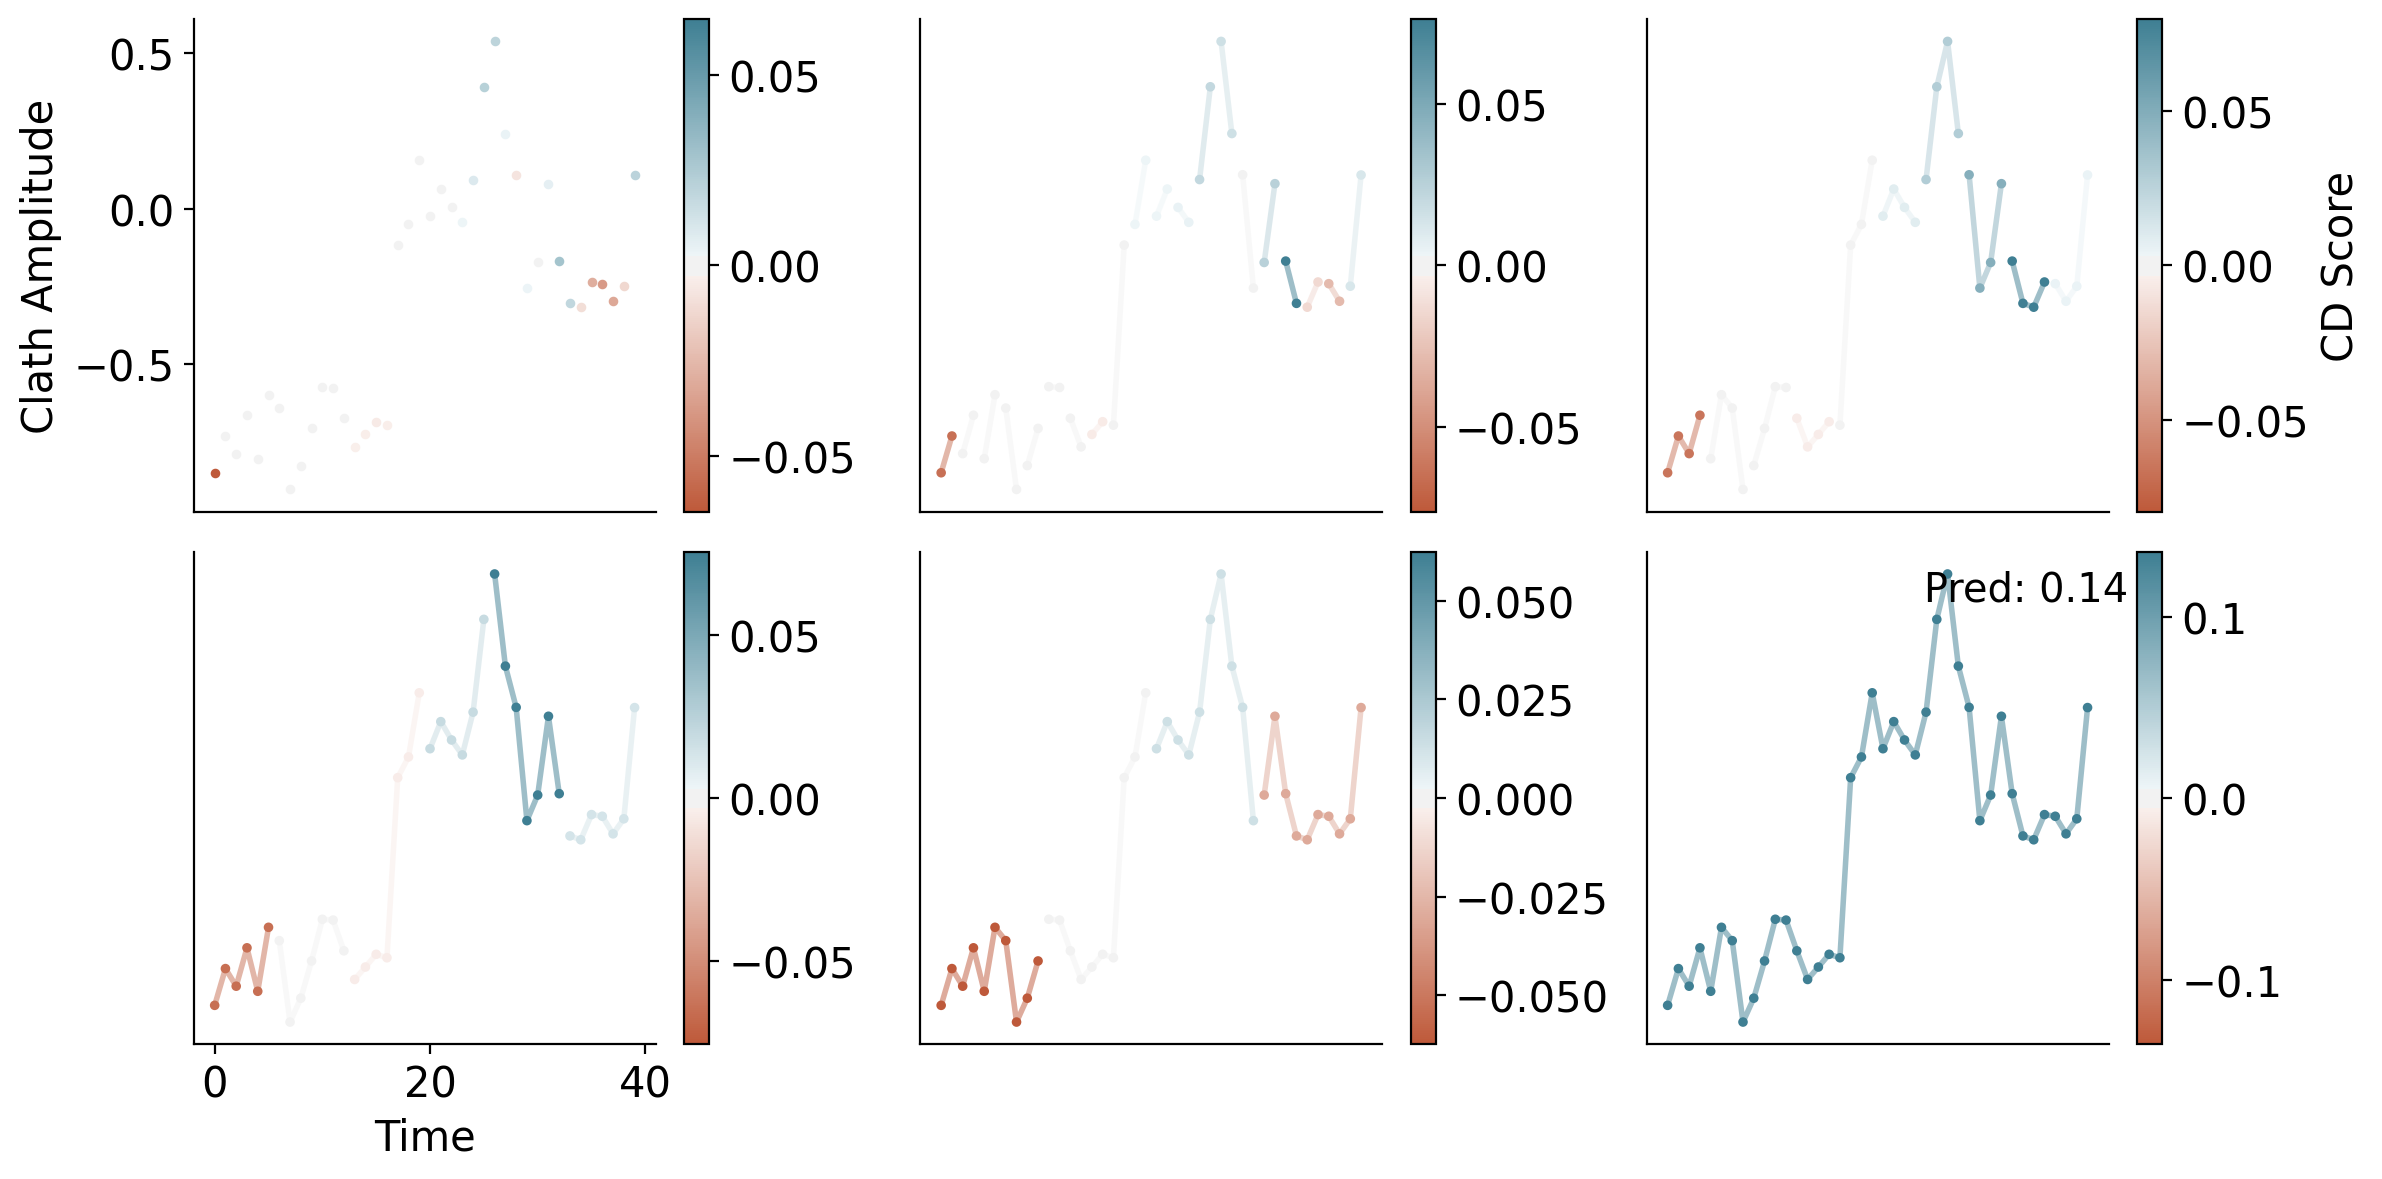

In [12]:
plt.figure(dpi=200, figsize=(12, 6))
R, C = 2, 3
for i, track_segs in enumerate(track_segs_list):
    ax = plt.subplot(R, C, i + 1)
    cd_scores = cd_scores_list[i]
    plot_segs(track_segs, cd_scores, xtrack.iloc[0], pred)
    
    if i == C * (R - 1):
        plt.xlabel('Time')
    else:
        plt.xticks([])
    if i == 0:
        plt.ylabel('Clath Amplitude')
    else:
        plt.yticks([])
    if i  == C - 1:
        plt.colorbar(label='CD Score')
    else:
        plt.colorbar()
    if i ==  C * R - 1:
        plt.text(0.6, 0.9,
                 f'Pred: {pred:.2f}', fontsize='x-large', transform = ax.transAxes)
plt.tight_layout()
plt.show()